In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from time import time
from multiprocessing import Process, Pool, cpu_count
import csv

% matplotlib inline

In [2]:
crimes = pd.read_csv('data/NYPD_Complaint_Data_Historic.csv')
population = pd.read_csv('data/Population_by_Borough_NYC.csv')
census = pd.read_csv('data/nyc_census_tracts.csv')
census_loc = pd.read_csv('data/census_block_loc.csv')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [65]:
crimes.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44.0,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)"
1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,103.0,OUTSIDE,NaN,NaN,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)"
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,28.0,NaN,OTHER,NaN,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)"
3,968417082,12/31/2015,23:30:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,105.0,INSIDE,RESIDENCE-HOUSE,NaN,NaN,1060183.0,177862.0,40.654549,-73.726339,"(40.654549444, -73.726338791)"
4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,13.0,FRONT OF,OTHER,NaN,NaN,987606.0,208148.0,40.738002,-73.987891,"(40.7380024, -73.98789129)"


In [118]:
print(census.shape)
census.head()

(2167, 36)


,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2


In [121]:
print(census_loc.shape)
census_loc.head()

(38396, 5)


,Latitude,Longitude,BlockCode,County,State
0,40.48,-74.280000,340230076002012,Middlesex,NJ
1,40.48,-74.276834,340230076005000,Middlesex,NJ
2,40.48,-74.273668,340230076003018,Middlesex,NJ
3,40.48,-74.270503,340230076003004,Middlesex,NJ
4,40.48,-74.267337,340230074021000,Middlesex,NJ


1117 types of crimes


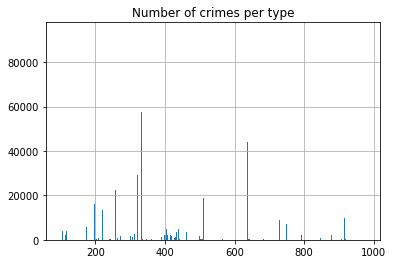

In [25]:
crimes[['PD_CD', 'PD_DESC']] # Crime type + description of type of offens
print("{} types of crimes".format(len(set(crimes['PD_CD']))))
plt.title("Number of crimes per type")
crimes['PD_CD'].hist(bins=len(set(crimes['PD_CD'])))

In [3]:
"""
Some dates were mistakenly registered in 1015. Those crimes probably happened in 2015
Let's drop them
"""
for elem in set(crimes['CMPLNT_FR_DT']):
    try:
        pd.to_datetime(elem)
    except:
        print(elem)
        
crimes = crimes[~ crimes['CMPLNT_FR_DT'].str.contains('1015').fillna(False)]

09/16/1015
10/17/1015
12/04/1015
11/25/1015
10/27/1015
09/26/1015


In [4]:
# Let's create a timestamp
crimes['Timestamp'] = pd.to_datetime(crimes['CMPLNT_FR_DT'] + ' ' + crimes['CMPLNT_FR_TM'], format="%m/%d/%Y %H:%M:%S")

In [92]:
# Description says crime report goes back 5 years let's only keep those values

print(crimes['Timestamp'].min(), crimes['Timestamp'].max())
crimes = crimes[crimes['Timestamp'] >= '01/01/2011']

2011-01-01 00:00:00 2015-12-31 23:45:00


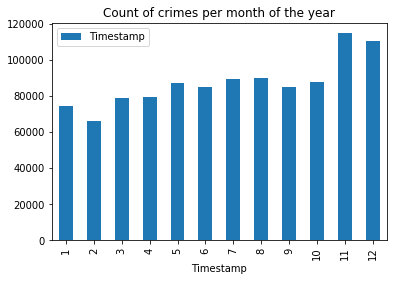

In [93]:
crimes[["Timestamp"]].groupby(crimes["Timestamp"].dt.month).count().plot(kind="bar", \
                                                                         title="Count of crimes per month of the year")

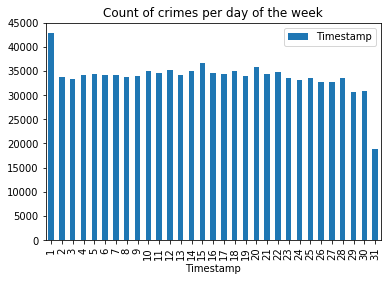

In [94]:
crimes[["Timestamp"]].groupby(crimes["Timestamp"].dt.day).count().plot(kind="bar", \
                                                                         title="Count of crimes per day of the week")

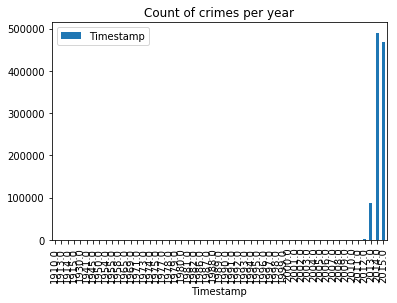

In [48]:
crimes[["Timestamp"]].groupby(crimes["Timestamp"].dt.year).count().plot(kind="bar", \
                                                                         title="Count of crimes per year")

# We should only keep data for 2014-2015...
crimes = crimes[crimes['Timestamp'] >= '01/01/2014']

In [ ]:
crimes[["Timestamp"]].groupby(crimes["Timestamp"].dt.year).count().plot(kind="bar", \
                                                                         title="Count of crimes per year")

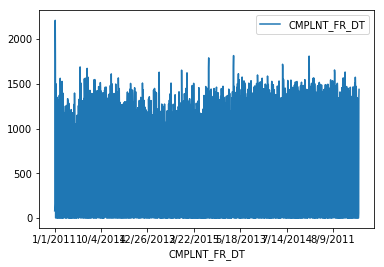

In [97]:
crimes[["CMPLNT_FR_DT"]].groupby([crimes["CMPLNT_FR_DT"]]).count().plot()
# High volatility

In [111]:
crimes[['CMPLNT_NUM', 'LAW_CAT_CD']].groupby('LAW_CAT_CD').count()

,CMPLNT_NUM
LAW_CAT_CD,
FELONY,327807
MISDEMEANOR,585468
VIOLATION,135300


In [211]:
# will not use this data: not enough values to work on
print(set(crimes['BORO_NM']))
print(set(census['Borough']))

crimes['BORO_NM'].replace('BRONX', 'Bronx', inplace=True)
crimes['BORO_NM'].replace('BROOKLYN', 'Brooklyn', inplace=True)
crimes['BORO_NM'].replace('STATEN ISLAND', 'Staten Island', inplace=True)
crimes['BORO_NM'].replace('MANHATTAN', 'Manhattan', inplace=True)
crimes['BORO_NM'].replace('QUEENS', 'Queens', inplace=True)
print(set(crimes['BORO_NM']))

{'BROOKLYN', 'Bronx', 'STATEN ISLAND', 'MANHATTAN', 'QUEENS'}
{'Bronx', 'Manhattan', 'Queens', 'Staten Island', 'Brooklyn'}
{'Bronx', 'Queens', 'Manhattan', 'Staten Island', 'Brooklyn'}


In [223]:
print(census['CensusTract'].head())
print(census_loc['BlockCode'].head())

print(census.shape)
print(census_loc.shape)

0    36005000100
1    36005000200
2    36005000400
3    36005001600
4    36005001900
Name: CensusTract, dtype: int64
0    340230076002012
1    340230076005000
2    340230076003018
3    340230076003004
4    340230074021000
Name: BlockCode, dtype: int64
(2167, 36)
(38396, 5)


In [226]:
census_loc

,Latitude,Longitude,BlockCode,County,State
0,40.48,-74.280000,340230076002012,Middlesex,NJ
1,40.48,-74.276834,340230076005000,Middlesex,NJ
2,40.48,-74.273668,340230076003018,Middlesex,NJ
3,40.48,-74.270503,340230076003004,Middlesex,NJ
4,40.48,-74.267337,340230074021000,Middlesex,NJ
5,40.48,-74.264171,340230074021000,Middlesex,NJ
6,40.48,-74.261005,340230074021000,Middlesex,NJ
7,40.48,-74.257839,340230074021000,Middlesex,NJ
8,40.48,-74.254673,340230074025000,Middlesex,NJ
9,40.48,-74.251508,340230074025000,Middlesex,NJ


## Find the block of crime

In [5]:
# Data from 2015 first
crimes = crimes[crimes['Timestamp'] >= '01/01/2015']

In [22]:
# year should be a parameter but does not seem to appear in the url!!
def find_block(row):
    latitude, longitude = float(row["Latitude"]), float(row["Longitude"])
    if latitude == latitude:
        r = requests.get('https://geo.fcc.gov/api/census/block/find?latitude={}&longitude={}&format=json'.format(latitude, longitude))
        return {"CMPLNT_NUM": row["CMPLNT_NUM"], "BLOCK": int(r.json()['Block']['FIPS'])}
    else:
        return {"CMPLNT_NUM": row["CMPLNT_NUM"], "BLOCK": np.nan}
    
# year should be a parameter but does not seem to appear in the url!!
def find_block_v2(row):
    latitude, longitude = float(row["Latitude"]), float(row["Longitude"])
    if latitude == latitude:
        r = urllib.request.urlopen('https://geo.fcc.gov/api/census/block/find?latitude={}&longitude={}&format=json'.format(latitude, longitude))
        return {"CMPLNT_NUM": row["CMPLNT_NUM"], "BLOCK": int(json.loads(r.read().decode('utf-8'))['Block']['FIPS'])}
    else:
        return {"CMPLNT_NUM": row["CMPLNT_NUM"], "BLOCK": np.nan}

In [74]:
rows = crimes[:200][["CMPLNT_NUM", "Latitude", "Longitude"]].to_dict('records')

cpus = cpu_count()
print(cpus, " cpu")
pool = Pool(processes=5)

start_time = time()
results = pool.map(find_block, rows)

print(time() - start_time)
print((time() - start_time) * crimes.shape[0] / 200 / 60 / 60, " hours")

4  cpu
12.646440029144287
8.231139498519898  hours


In [24]:
rows = crimes[:200][["CMPLNT_NUM", "Latitude", "Longitude"]].to_dict('records')

cpus = cpu_count()
print(cpus, " cpu")

keys = ["BLOCK", "CMPLNT_NUM"]

with open('test.csv', 'w') as output_file:
    csvwriter = csv.writer(output_file, delimiter=',')
    pool = Pool(processes=5)

    start_time = time()
    results = pool.map(find_block, rows)

print(time() - start_time)
print((time() - start_time) * crimes.shape[0] / 200 / 60 / 60, " hours")

4  cpu
13.991364002227783
9.105849675941467  hours


In [23]:
import urllib.request
import json

rows = crimes[:200][["CMPLNT_NUM", "Latitude", "Longitude"]].to_dict('records')

cpus = cpu_count()
print(cpus, " cpu")

keys = ["BLOCK", "CMPLNT_NUM"]

with open('test.csv', 'w') as output_file:
    csvwriter = csv.writer(output_file, delimiter=',')
    pool = Pool(processes=5)

    start_time = time()
    results = pool.map(find_block_v2, rows)

print(time() - start_time)
print((time() - start_time) * crimes.shape[0] / 200 / 60 / 60, " hours")

4  cpu
12.072597026824951
7.857113025093079  hours


In [34]:
cpus = cpu_count()
print(cpus, " cpu")
chunks = [(20000 * k, 20000 * (k + 1)) for k in range(int(crimes.shape[0] / 20000))]

for chunk in chunks[15:]:
    print("Chunk {}".format(chunk))
    rows = crimes[chunk[0]:chunk[1]][["CMPLNT_NUM", "Latitude", "Longitude"]].to_dict('records')
    
    pool = Pool(processes=cpus)

    start_time = time()
    results = pool.map(find_block_v2, rows)
    
    pd.DataFrame(results).to_csv("data/crime_blocks_{}.csv".format(chunk))

4  cpu
Chunk (300000, 320000)
Chunk (320000, 340000)
Chunk (340000, 360000)
Chunk (360000, 380000)
Chunk (380000, 400000)
Chunk (400000, 420000)
Chunk (420000, 440000)
Chunk (440000, 460000)


In [33]:
chunks[15:]

[(300000, 320000),
 (320000, 340000),
 (340000, 360000),
 (360000, 380000),
 (380000, 400000),
 (400000, 420000),
 (420000, 440000),
 (440000, 460000)]